Based on:

* https://www.kaggle.com/sidhue96/vgg16-transfer-learning-using-pytorch
* A deepsense.ai blog post Keras vs. PyTorch - Alien vs. Predator recognition with transfer learning in which we compare and contrast Keras and PyTorch approaches.
* https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


Changes:

* Change to resnet50 (actually, I found resnet18 is enough)
* Add lr_scheduler from step to ReduceLROnPlateau

In [1]:
from __future__ import print_function, division

import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  


In [2]:
torch.__version__

'1.4.0'

In [3]:
torchvision.__version__

'0.5.0'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
data_transforms = {
    'train': transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.32)], p=0.4),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

data_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray'
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in ['train', 'val', 'test']
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in ['train', 'val', 'test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

for x in ['train', 'val', 'test']:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets['train'].classes
print(image_datasets['train'].classes)

Loaded 5216 images under train
Loaded 16 images under val
Loaded 624 images under test
Classes: 
['NORMAL', 'PNEUMONIA']


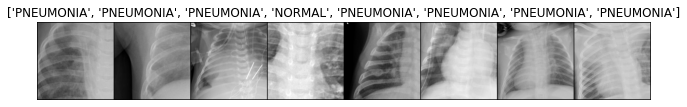

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(11, 11))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
show_databatch(inputs, classes)

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    last_end = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            epoch_time = time.time() - last_end
            last_end = time.time()
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            print('Epoch Time {epoch_time:.3f}'.format(epoch_time=epoch_time))
            if phase == 'train':
                scheduler.step(epoch_loss)
            else:
                print('-' * 10)
    return model

In [8]:
# Load the pretrained model from pytorch
model = models.resnet50(pretrained=True).to(device)

# print(model)
# Freeze training for all layers
for param in model.parameters():
    param.requires_grad = False

# Newly created modules have require_grad=True by default
# Dropout(p=0.5) is also a good new layer
model.fc = nn.Sequential(
               nn.Linear(2048, 2)).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [9]:
criterion = nn.CrossEntropyLoss()
# Optimzer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# LR scheduler
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                    patience=4,
                                                    cooldown=0,
                                                    verbose=True)


In [10]:
model = train_model(model, criterion, optimizer, lr_scheduler, num_epochs=8)

Epoch 1/8
----------
train loss: 0.3761, acc: 0.8374
Epoch Time 73.643
val loss: 0.7453, acc: 0.7500
Epoch Time 0.548
----------
Epoch 2/8
----------
train loss: 0.3471, acc: 0.8482
Epoch Time 70.848
val loss: 0.7895, acc: 0.6875
Epoch Time 0.445
----------
Epoch 3/8
----------
train loss: 0.3155, acc: 0.8712
Epoch Time 71.220
val loss: 0.6965, acc: 0.7500
Epoch Time 0.485
----------
Epoch 4/8
----------
train loss: 0.3275, acc: 0.8643
Epoch Time 461.806
val loss: 1.3917, acc: 0.6250
Epoch Time 0.474
----------
Epoch 5/8
----------
train loss: 0.3273, acc: 0.8637
Epoch Time 70.643
val loss: 0.5593, acc: 0.8125
Epoch Time 0.442
----------
Epoch 6/8
----------
train loss: 0.3222, acc: 0.8652
Epoch Time 71.174
val loss: 0.6875, acc: 0.8125
Epoch Time 0.562
----------
Epoch 7/8
----------
train loss: 0.3258, acc: 0.8646
Epoch Time 71.592
val loss: 1.5817, acc: 0.5625
Epoch Time 0.644
----------
Epoch 8/8
----------
train loss: 0.3021, acc: 0.8714
Epoch Time 72.662
val loss: 1.0276, acc: 0.

In [11]:
def test_model(model, criterion):
    last_end = time.time()
    print('-' * 10)
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(image_datasets['test'])
    epoch_acc = running_corrects.double() / len(image_datasets['test'])
    epoch_time = time.time() - last_end
    last_end = time.time()
    print('Test loss: {:.4f}, acc: {:.4f}'.format(epoch_loss,
                                                  epoch_acc))
    print('Test Time {epoch_time:.3f}'.format(epoch_time=epoch_time))
    print('-' * 10)

In [12]:
test_model(model, criterion)

----------
Test loss: 0.4059, acc: 0.8702
Test Time 10.322
----------


In [13]:
!mkdir models
!mkdir models/pytorch
torch.save(model.state_dict(), 'models/pytorch/weights.h5')

In [14]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 2)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

<All keys matched successfully>

In [15]:
validation_img_paths = ["test/NORMAL/IM-0001-0001.jpeg",
                        "test/NORMAL/IM-0003-0001.jpeg",
                        "test/PNEUMONIA/person100_bacteria_475.jpeg",
                        "test/PNEUMONIA/person100_bacteria_477.jpeg"]
img_list = [Image.open(data_dir + '/' + img_path).convert('RGB') for img_path in validation_img_paths]

In [16]:
validation_batch = torch.stack([data_transforms['test'](img).to(device)
                                for img in img_list])

In [17]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[-0.6896,  0.5559],
        [-1.2866,  1.3753],
        [-0.4079,  0.3546],
        [-2.2818,  2.7047]], device='cuda:0', grad_fn=<AddmmBackward>)

In [18]:
pred_probs = nn.functional.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.2234911 , 0.77650887],
       [0.06525648, 0.9347435 ],
       [0.31809786, 0.68190217],
       [0.0067837 , 0.99321634]], dtype=float32)

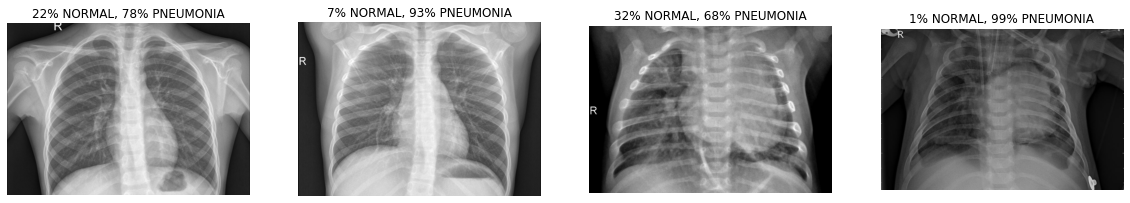

In [19]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% NORMAL, {:.0f}% PNEUMONIA".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)